# Set Environment

In [1]:
# 필요 package 설치
!pip install pytorch_tabnet     # tabnet 모델 설치
!pip install catboost           # catboost 모델 설치
!pip install ctgan==0.3.1.dev0  # gan 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 661 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.3 MB 8.5 MB/s 
     |████████████████████████████████| 6.8 MB 43.0 MB/s 
     |████████████████████████████████| 1.1 MB 87.0 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages t

In [2]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SKKU_study/01_Final_assignment/source/make_module

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1LV52TPokqNSxVzliYdaMCeFRl_ycAZHQ/SKKU_study/01_Final_assignment/source/make_module


In [3]:
# import Custom packages
from model_tabnet import ModelTabnet
from model_forest import ModelForest
from model_catboost import ModelCatBoost
from ensemble_hard import Hard_voting
from ensemble_soft import EnsembleSoft
import Matrics
import sampling

# import packages
from ctgan import CTGANSynthesizer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from collections import Counter
import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

In [4]:
# set directories
main_dir = '/content/drive/MyDrive/SKKU_study/01_Final_assignment'
data_dir = os.path.join(main_dir, 'data')
processed_data_dir = os.path.join(data_dir, 'processed')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(processed_data_dir, exist_ok=True)

# Load Dataset (Vanilla)

In [5]:
dfs = pd.read_csv(os.path.join(processed_data_dir, 'processed.csv'))
train = pd.read_csv(os.path.join(processed_data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(processed_data_dir, 'test.csv'))

all_col_list = [col for col in dfs.columns if col != 'Credit_Score']
train.shape, test.shape # original shape check

((75000, 23), (25000, 23))

# Sampling
- naming rule
    - 'train_샘플링이름' 형태로 train data만 대상으로 sampling된 데이터 생성하는 코드로 작성 부탁 드립니다.

## SMOTENC

In [7]:
# ratio = {0: 21782, 1: 40214, 2: 13004}
train_smtnc = sampling.train_smote_nc(train, 'auto')
print('sampled with SMOTENC dataset shape %s' % Counter(train_smtnc['Credit_Score']))

KeyboardInterrupt: ignored

## SMOTE + Tomeklink

In [ ]:
# ratio = {0: 21782, 1: 40214, 2: 13004} 
train_smttm = sampling.train_smote_tomek(train, 'auto')
print('sampled with SMOTETOMEK dataset shape %s' % Counter(train_smttm['Credit_Score']))

sampled with SMOTETOMEK dataset shape Counter({2: 39177, 0: 38217, 1: 37268})


## GAN
- good/poor/standard = 1:1:1 비율선정하여 output code 추가예정

In [ ]:
# gan model은 시간상의 문제로 인해 기존 생성되어 있는 over sampled file 직접 로드하는 형식으로 작성 필요
# train_gan=sampling.train_gan(train)
train_gan = pd.read_csv(os.path.join(data_dir, 'output_GAN_data', 'generate_gan_v4.csv'))
train_gan.drop(columns='Unnamed: 0', inplace=True)

random_list = [] # class 0은 9000개정도 oversampling
for i in range(0, 5000):
    random_list.append(random.randint(0, 12499))
train_gan_0 = train_gan[
    (train_gan.Credit_Score==0) &
    (train_gan.Customer_ID.isin(random_list))
    ]

train_gan_2 = train_gan[train_gan.Credit_Score==2]
train_gan = pd.concat([train_gan_0, train_gan_2], ignore_index=True)
train_gan = pd.concat([train_gan, train], ignore_index=True)
print('sampled with GAN dataset shape %s' % Counter(train_gan['Credit_Score']))

sampled with GAN dataset shape Counter({1: 40214, 0: 31393, 2: 29886})


# Modeling
- 3개 모델 X 4개 

## TABNET

### Vanilla

In [8]:
model_tabnet = ModelTabnet(
    dfs_train=train,
    dfs_test=test,
)
tabnet_proba = model_tabnet.predicted_proba

Customer_ID :  12500
Month :  8
Credit_Mix :  3
Credit_History_Age :  2
Occupation :  15
Payment_of_Min_Amount :  3
Payment_Behaviour :  6
!!!Pretrain Start!!!
epoch 0  | loss: 6.09609 |  0:00:06s
epoch 1  | loss: 2.27443 |  0:00:10s
epoch 2  | loss: 1.57849 |  0:00:13s
epoch 3  | loss: 1.25393 |  0:00:17s
epoch 4  | loss: 1.12535 |  0:00:21s
epoch 5  | loss: 1.05374 |  0:00:25s
epoch 6  | loss: 1.03537 |  0:00:28s
epoch 7  | loss: 1.02312 |  0:00:32s
epoch 8  | loss: 1.01701 |  0:00:36s
epoch 9  | loss: 0.99932 |  0:00:40s
epoch 10 | loss: 0.98379 |  0:00:43s
epoch 11 | loss: 0.97336 |  0:00:47s
epoch 12 | loss: 0.96717 |  0:00:51s
epoch 13 | loss: 0.9616  |  0:00:54s
epoch 14 | loss: 0.95874 |  0:00:58s
epoch 15 | loss: 0.95478 |  0:01:02s
epoch 16 | loss: 0.95418 |  0:01:06s
epoch 17 | loss: 0.95004 |  0:01:09s
epoch 18 | loss: 0.94478 |  0:01:13s
epoch 19 | loss: 0.93711 |  0:01:17s
epoch 20 | loss: 0.93312 |  0:01:21s
epoch 21 | loss: 0.92902 |  0:01:24s
epoch 22 | loss: 0.92484 |

In [9]:
# feature importance of tabnet
print('*** Feature Importance of TABNET ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_tabnet.model_tabnet.feature_importances_.round(3)[i])

*** Feature Importance of TABNET ***
Customer_ID :  0.446
Month :  0.0
Age :  0.008
Occupation :  0.0
Monthly_Inhand_Salary :  0.0
Num_Bank_Accounts :  0.081
Num_Credit_Card :  0.0
Interest_Rate :  0.007
Num_of_Loan :  0.0
Delay_from_due_date :  0.001
Num_of_Delayed_Payment :  0.002
Changed_Credit_Limit :  0.01
Num_Credit_Inquiries :  0.006
Credit_Mix :  0.001
Outstanding_Debt :  0.1
Credit_Utilization_Ratio :  0.0
Credit_History_Age :  0.06
Payment_of_Min_Amount :  0.004
Total_EMI_per_month :  0.008
Amount_invested_monthly :  0.012
Payment_Behaviour :  0.205
Monthly_Balance :  0.047


In [10]:
# check probability of tabnet predict result
tabnet_proba.head()

,ID,model,Poor,Standard,Good
0,0,TABNET,1.852557e-06,0.004825,0.995173
1,1,TABNET,1.420157e-06,0.004084,0.995915
2,2,TABNET,3.384023e-05,0.093751,0.906215
3,3,TABNET,1.858773e-05,0.040869,0.959113
4,4,TABNET,1.743291e-07,0.003041,0.996959


### SMOTENC

In [ ]:
model_tabnet_smtnc = ModelTabnet(
    dfs_train=train,
    dfs_test=test,
    dfs_sampled=train_smtnc,
)
tabnet_proba_smtnc = model_tabnet_smtnc.predicted_proba

In [ ]:
# feature importance of tabnet x SMOTENC
print('*** Feature Importance of TABNET x SMOTENC ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_tabnet_smtnc.model_tabnet.feature_importances_.round(3)[i])

In [ ]:
tabnet_proba_smtnc.head()

### SMOTE + Tomeklink

In [ ]:
model_tabnet_smttm = ModelTabnet(
    dfs_train=train,
    dfs_test=test,
    dfs_sampled=train_smttm,
)
tabnet_proba_smttm = model_tabnet_smttm.predicted_proba

In [ ]:
# feature importance of tabnet X SMOTETOMEK
print('*** Feature Importance of TABNET X SMOTETOMEK ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_tabnet_smttm.model_tabnet.feature_importances_.round(3)[i])

In [ ]:
tabnet_proba_smttm.head()

### GAN

In [ ]:
model_tabnet_gan = ModelTabnet(
    dfs_train=train,
    dfs_test=test,
    dfs_sampled=train_gan,
)
tabnet_proba_gan = model_tabnet_gan.predicted_proba

In [ ]:
# feature importance of tabnet X GAN
print('*** Feature Importance of TABNET X GAN ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_tabnet_gan.model_tabnet.feature_importances_.round(3)[i])

In [ ]:
tabnet_proba_gan.head()

### Select Best Model with TABNET

In [ ]:
# acc_vanilla = accuracy_score(test['Credit_Score'], model_tabnet.predict['predict'])
# acc_smtnc = accuracy_score(test['Credit_Score'], model_tabnet_smtnc.predict['predict'])
# acc_smttm = accuracy_score(test['Credit_Score'], model_tabnet_smttm.predict['predict'])
# acc_gan = accuracy_score(test['Credit_Score'], model_tabnet_gan.predict['predict'])

acc_vanilla = f1_score(test['Credit_Score'], model_tabnet.predict['predict'])
acc_smtnc = f1_score(test['Credit_Score'], model_tabnet_smtnc.predict['predict'])
acc_smttm = f1_score(test['Credit_Score'], model_tabnet_smttm.predict['predict'])
acc_gan = f1_score(test['Credit_Score'], model_tabnet_gan.predict['predict'])

accuracy_dict = {
    'Vanilla': acc_vanilla,
    'SMOTENC': acc_smtnc,
    'SMOTETOMEK': acc_smttm,
    'GAN': acc_gan,
}
best_acc = max(accuracy_dict.values())
best_model_idx = list(accuracy_dict.values()).index(best_acc)
best_model = list(accuracy_dict.keys())[best_model_idx]
# print('Best TABNET accuracy is ', best_acc, 'with ', best_model)
print('Best TABNET f1 score is ', best_acc, 'with ', best_model)

if best_model == 'Vanilla':
    best_tabnet = model_tabnet
elif best_model == 'SMOTENC':
    best_tabnet = model_tabnet_smtnc
elif best_model == 'SMOTETOMEK':
    best_tabnet = model_tabnet_smttm
else:
    best_tabnet = model_tabnet_gan

## RF

### Vanilla

In [11]:
model_forest = ModelForest(
    train,
    test,
    "plain"
)
result_forest = model_forest.predict_proba

In [12]:
# feature importance
print('*** Feature Importance of RandomForest ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_forest.feature_importance.round(3)[i])

*** Feature Importance of RandomForest ***
Customer_ID :  0.042
Month :  0.035
Age :  0.017
Occupation :  0.028
Monthly_Inhand_Salary :  0.046
Num_Bank_Accounts :  0.041
Num_Credit_Card :  0.037
Interest_Rate :  0.095
Num_of_Loan :  0.008
Delay_from_due_date :  0.072
Num_of_Delayed_Payment :  0.038
Changed_Credit_Limit :  0.015
Num_Credit_Inquiries :  0.059
Credit_Mix :  0.104
Outstanding_Debt :  0.122
Credit_Utilization_Ratio :  0.039
Credit_History_Age :  0.016
Payment_of_Min_Amount :  0.038
Total_EMI_per_month :  0.043
Amount_invested_monthly :  0.042
Payment_Behaviour :  0.019
Monthly_Balance :  0.043


In [13]:
result_forest.head()

,ID,model,Poor,Standard,Good
0,0,RF,0.04,0.22,0.74
1,1,RF,0.01,0.13,0.86
2,2,RF,0.02,0.30,0.68
3,3,RF,0.04,0.29,0.67
4,4,RF,0.01,0.03,0.96


### SmoteNC

In [ ]:
model_forest_smtnc = ModelForest(
    train_smtnc,
    test, "plain"

)
forest_proba_smtnc = model_forest_smtnc.predict_proba

In [ ]:
# feature importance
print('*** Feature Importance of RandomForest x SMOTETNC ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_forest_smtnc.feature_importance.round(3)[i])


In [ ]:
# proba.head
forest_proba_smtnc.head()


### SMOTE + Tomeklink

In [ ]:
model_forest_smttm = ModelForest(
    train_smttm,
    test ,"plain"

)
forest_proba_smttm = model_forest_smttm.predict_proba

In [ ]:
# feature importance
print('*** Feature Importance of RandomForest x SMOTETOMEK ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_forest_smttm.feature_importance.round(3)[i])

In [ ]:
forest_proba_smttm.head()

### GAN

In [ ]:
model_forest_gan = ModelForest(
    train_gan,
    test,
    "plain"
)
forest_proba_gan = model_forest_gan.predict_proba

In [ ]:
# feature importance
print('*** Feature Importance of RandomForest x GAN ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_forest_gan.feature_importance.round(3)[i])

In [ ]:
forest_proba_gan.head()

### Select Best Model with RF

In [ ]:
acc_vanilla = accuracy_score(test['Credit_Score'], model_forest.predict['predict'])
acc_smtnc = accuracy_score(test['Credit_Score'], model_forest_smtnc.predict['predict'])
acc_smttm = accuracy_score(test['Credit_Score'], model_forest_smttm.predict['predict'])
acc_gan = accuracy_score(test['Credit_Score'], model_forest_gan.predict['predict'])

accuracy_dict = {
    'Vanilla': acc_vanilla,
    'SMOTENC': acc_smtnc,
    'SMOTETOMEK': acc_smttm,
    'GAN': acc_gan
}
best_acc = max(accuracy_dict.values())
best_model_idx = list(accuracy_dict.values()).index(best_acc)
best_model = list(accuracy_dict.keys())[best_model_idx]
print('Best RANDOM FOREST accuracy is ', best_acc, 'with ', best_model)

if best_model == 'Vanilla':
    best_rf = model_forest
elif best_model == 'SMOTENC':
    best_rf = model_forest_smtnc
elif best_model =='GAN':
    best_rf = model_forest_gan
else:
    best_rf = model_forest_smttm

## CatBoost

### Vanilla

In [14]:
model_catboost = ModelCatBoost(
    train,
    test,
    "optimize"
)

0:	learn: 1.0524323	total: 562ms	remaining: 9m 21s
1:	learn: 1.0076542	total: 1.06s	remaining: 8m 49s
2:	learn: 0.9684652	total: 1.54s	remaining: 8m 31s
3:	learn: 0.9351590	total: 2.02s	remaining: 8m 21s
4:	learn: 0.9076541	total: 2.49s	remaining: 8m 16s
5:	learn: 0.8829301	total: 2.98s	remaining: 8m 13s
6:	learn: 0.8604031	total: 3.19s	remaining: 7m 32s
7:	learn: 0.8415306	total: 3.68s	remaining: 7m 36s
8:	learn: 0.8292816	total: 4.18s	remaining: 7m 40s
9:	learn: 0.8062957	total: 4.22s	remaining: 6m 57s
10:	learn: 0.7918187	total: 4.71s	remaining: 7m 3s
11:	learn: 0.7827413	total: 5.18s	remaining: 7m 6s
12:	learn: 0.7755620	total: 5.67s	remaining: 7m 10s
13:	learn: 0.7657157	total: 6.16s	remaining: 7m 13s
14:	learn: 0.7595937	total: 6.64s	remaining: 7m 16s
15:	learn: 0.7517415	total: 7.13s	remaining: 7m 18s
16:	learn: 0.7436451	total: 7.61s	remaining: 7m 20s
17:	learn: 0.7367319	total: 8.09s	remaining: 7m 21s
18:	learn: 0.7323850	total: 8.57s	remaining: 7m 22s
19:	learn: 0.7267958	tot

In [ ]:
print('*** Feature Importance of CatBoost ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_catboost.feature_importance.round(3)[i])

In [ ]:
result_catboost = model_catboost.predict_proba
result_catboost.head()

### SMOTENC

In [ ]:
model_cat_smtnc = ModelCatBoost(
    train_smtnc,
    test,'optimize'
)
cat_proba_smtnc = model_cat_smtnc.predict_proba

In [ ]:
# feature importance
print('*** Feature Importance of CATBOOST x SMOTETNC ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_cat_smtnc.feature_importance.round(3)[i])


In [ ]:
# proba.head
cat_proba_smtnc.head()


### SMOTE + Tomeklink

In [ ]:
model_cat_smttm = ModelCatBoost(
    train_smttm,
    test,'optimize'
)
cat_proba_smttm = model_cat_smttm.predict_proba

In [ ]:
# feature importance
print('*** Feature Importance of CATBOOST x SMOTETOMEK ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_cat_smttm.feature_importance.round(3)[i])

In [ ]:
cat_proba_smttm.head()

### GAN

In [ ]:
model_cat_gan = ModelCatBoost(
    train_gan,
    test,'optimize'
)
cat_proba_gan = model_cat_gan.predict_proba

In [ ]:
# feature importance
print('*** Feature Importance of CATBOOST x GAN ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_cat_gan.feature_importance.round(3)[i])

In [ ]:
cat_proba_gan.head()

### Select Best Model with CatBoot

In [ ]:
acc_vanilla = accuracy_score(test['Credit_Score'], model_catboost.predict['predict'])
acc_smtnc = accuracy_score(test['Credit_Score'], model_cat_smtnc.predict['predict'])
acc_smttm = accuracy_score(test['Credit_Score'], model_cat_smttm.predict['predict'])
acc_gan = accuracy_score(test['Credit_Score'], model_cat_gan.predict['predict'])

accuracy_dict = {
    'Vanilla': acc_vanilla,
    'SMOTENC': acc_smtnc,
    'SMOTETOMEK': acc_smttm,
    'GAN' : acc_gan
}
best_acc = max(accuracy_dict.values())
best_model_idx = list(accuracy_dict.values()).index(best_acc)
best_model = list(accuracy_dict.keys())[best_model_idx]
print('Best CATBOOST accuracy is ', best_acc, 'with ', best_model)

if best_model == 'Vanilla':
    best_cat = model_catboost
elif best_model == 'SMOTENC':
    best_cat = model_cat_smtnc
elif best_model == 'GAN':
    best_cat = model_cat_gan
else:
    best_cat = model_cat_smttm

# Ensemble
- Ensemble with Best 3 Models From TABNET, RF, CatBoost individually

## Hard Voting

In [15]:
# proba concat (25000 * 3)
merge_proba = pd.concat([model_tabnet.predicted_proba, model_forest.predict_proba,model_catboost.predict_proba])
merge_proba

,ID,model,Poor,Standard,Good
0,0,TABNET,1.852557e-06,0.004825,0.995173
1,1,TABNET,1.420157e-06,0.004084,0.995915
2,2,TABNET,3.384023e-05,0.093751,0.906215
3,3,TABNET,1.858773e-05,0.040869,0.959113
4,4,TABNET,1.743291e-07,0.003041,0.996959
...,...,...,...,...,...
24995,24995,Cat,2.665470e-02,0.134337,0.839009
24996,24996,Cat,4.024915e-01,0.496890,0.100619
24997,24997,Cat,4.031362e-01,0.413981,0.182883
24998,24998,Cat,7.353871e-01,0.179025,0.085588


In [16]:
result_hv = Hard_voting(merge_proba).predict
result_hv.head()

,ID,predict
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2


## Soft Voting
soft_ratio: 

```
[[tabnet 0 class probability, catboost 0 class probability, rf 0 class probability],
[tabnet 1 class probability, catboost 1 class probability, rf 1 class probability],
[tabnet 2 class probability, catboost 2 class probability, rf 2 class probability]]
```




In [19]:
# soft_ratio가 없는 경우 기본 값은 1:1:1
ensemble_soft = EnsembleSoft(model_tabnet.predicted_proba, result_forest, model_catboost.predict_proba)
ensemble_soft.predict_proba

,ID,Poor,Standard,Good
0,0,0.022107,0.105568,0.872326
1,1,0.008803,0.071747,0.919450
2,2,0.016754,0.168696,0.814550
3,3,0.035563,0.175729,0.788708
4,4,0.032686,0.032246,0.935068
...,...,...,...,...
24995,24995,0.042227,0.156440,0.801333
24996,24996,0.457688,0.505158,0.037154
24997,24997,0.297294,0.597848,0.104858
24998,24998,0.777972,0.166780,0.055248


In [20]:
print('accuracy: ', accuracy_score(test['Credit_Score'], ensemble_soft.predict['predict']))

accuracy:  0.74936


In [ ]:
# soft_ratio 지정하여 최적의 성능 내는 ratio test 중임 (sampling에서 최적 구한거 가지고 빡쎄게 tuning 필요할듯)
# soft_ratio = [[0.35, 0.65/2, 0.65/2], [0.3, 0.35, 0.35], [0.35, 0.65/2, 0.65/2]]
# ensemble_soft = EnsembleSoft(tabnet_proba, result_forest, result_catboost, soft_ratio=soft_ratio)
# ensemble_soft.predict_proba

In [ ]:
# print('accuracy: ', accuracy_score(test['Credit_Score'], ensemble_soft.predict['predict']))

# Performance
- target: 5 models
    - 3 simple models with Best matching sampled dataset
    - ensemble with hard voting model
    - ensemble with soft voting model
- 1st section: barchart
    - f1 score, accuracy, auroc(ovr), auroc(ovo), auprc(ap)
- 2nd section: roc_curve, pr_curve (w/ 수치)
- 3rd section: confusion metrics

## Metrics for Unbalanced Dataset

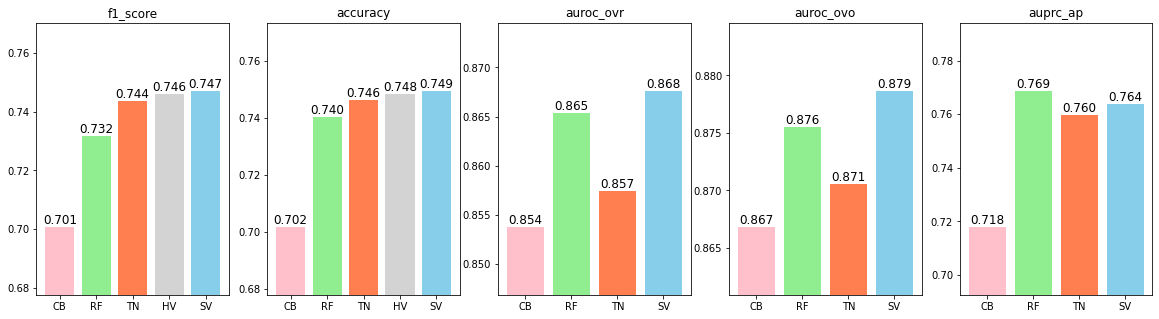

In [23]:
# vanilla + hard ,soft
proba_list = [model_catboost.predict_proba,result_forest,tabnet_proba, ensemble_soft.predict_proba]
pred_list = [model_catboost.predict, model_forest.predict, model_tabnet.predict,result_hv,ensemble_soft.predict]

Matrics.Compare_Model(proba_list,pred_list,test)

In [ ]:
# best + hard ,soft

proba_list = [best_cat.predict_proba,best_rf.predict_proba,best_tabnet.predicted_proba,ensemble_soft.predict_proba]
pred_list = [best_cat.predict, best_rf.predict, best_tabnet.predict ,result_hv,ensemble_soft.predict]

Matrics.Compare_Model(proba_list,pred_list,test)

## Graph for Unbalanced Dataset


In [24]:
# PR Curve
Matrics.PR_Curve(proba_list,test)

NameError: ignored

In [ ]:
# ROC Curve
Matrics.ROC_Curve(proba_list,test)

In [ ]:
# proba_list = [best_cat.predict_proba,best_rf.predict_proba,best_tabnet.predicted_proba,ensemble_soft.predict_proba]
# Matrics.PR_Curve(proba_list,test)
# Matrics.ROC_Curve(proba_list,test)

## Confusion Metrics
